In [ ]:
library(tidyverse)
library("tximeta")
library("DESeq2")
library("readr")
library("apeglm")
library("EnhancedVolcano")
library(eulerr)
library(randomForest)
library(caret)
library(Boruta)
library(glmnet)
library(ggpubr)
library(MLeval)
library(e1071) 
library(clusterProfiler)
library(org.Hs.eg.db)
library(writexl)

# DEG analysis
## CFS_1

In [ ]:
### Uploading metadata for dataset splitting
experiment_index <- "CFS_1"
dir <- paste0("C:/Users/User/Documents/project/", experiment_index)
samples <- read.table(paste0(dir, "/metadata.csv"), header=TRUE, sep=',')
samples$disease_state[samples$disease_state == "ME/CFS patients"] <- "ME/CFS patient"
rownames(samples) <- samples$nice_filename_index


### Splitting samples for train and test datasets. 
### DEG analysis and logistic regression was performed on train data only.
set.seed(123)
train_index <- createDataPartition(interaction(samples$disease_state, 
                                               samples$sex, 
                                               samples$Instrument), 
                                   p = 0.8, list = FALSE)
train_samples <- samples[train_index, ]
test_samples <- samples[-train_index, ]

### Features distribution for train and test data
table(interaction(train_samples$disease_state, train_samples$sex))
table(interaction(test_samples$disease_state, test_samples$sex))

In [ ]:
####### Preprocessing ####### 

### For train dataset
coldata <- train_samples
files <- file.path(dir, "quants", paste0(train_samples$nice_filename_index, "_quant"), "quant.sf")
names(files) <- train_samples$nice_filename_index
coldata$files <- files
coldata$names <- coldata$nice_filename_index

### Salmon quant data anotation
se <- tximeta(coldata)
gse <- summarizeToGene(se, assignRanges="abundant")
tpm_matrix_train <- t(assays(gse)[["abundance"]])

samples_df <- samples[, c("sex", "disease_state")] %>%
  mutate(disease_state = case_when(
    disease_state == "ME/CFS patient" ~ "ME/CFS (non-PI)",
    disease_state == "healthy control" ~ "healthy control"
  ))
merged_df_CFS_1 <- merge(tpm_matrix_train, samples_df, by = "row.names")
write.csv(merged_df_CFS_1, "merged_df_CFS_1.csv", row.names = FALSE)


### Same for the test dataset
coldata_test <- test_samples
files <- file.path(dir, "quants", paste0(test_samples$nice_filename_index, "_quant"), "quant.sf")
names(files) <- coldata_test$nice_filename_index
coldata_test$files <- files
coldata_test$names <- coldata_test$nice_filename_index

se_test <- tximeta(coldata_test)
gse_test <- summarizeToGene(se_test, assignRanges="abundant")
tpm_matrix_test <- t(assays(gse_test)[["abundance"]])


merged_df_CFS_1_test <- merge(tpm_matrix_test, samples_df, by = "row.names")
write.csv(merged_df_CFS_1_test, "merged_df_CFS_1_test.csv", row.names = FALSE)

In [ ]:
####### Preprocessing ####### 

### For train dataset
coldata <- train_samples
files <- file.path(dir, "quants", paste0(train_samples$nice_filename_index, "_quant"), "quant.sf")
names(files) <- train_samples$nice_filename_index
coldata$files <- files
coldata$names <- coldata$nice_filename_index

### Salmon quant data anotation
se <- tximeta(coldata)
gse <- summarizeToGene(se, assignRanges="abundant")
tpm_matrix_train <- t(assays(gse)[["abundance"]])

samples_df <- samples[, c("sex", "disease_state")] %>%
  mutate(disease_state = case_when(
    disease_state == "ME/CFS patient" ~ "ME/CFS (non-PI)",
    disease_state == "healthy control" ~ "healthy control"
  ))
merged_df_CFS_1 <- merge(tpm_matrix_train, samples_df, by = "row.names")
write.csv(merged_df_CFS_1, "merged_df_CFS_1.csv", row.names = FALSE)


### Same for test dataset
coldata_test <- test_samples
files <- file.path(dir, "quants", paste0(test_samples$nice_filename_index, "_quant"), "quant.sf")
names(files) <- coldata_test$nice_filename_index
coldata_test$files <- files
coldata_test$names <- coldata_test$nice_filename_index

se_test <- tximeta(coldata_test)
gse_test <- summarizeToGene(se_test, assignRanges="abundant")
tpm_matrix_test <- t(assays(gse_test)[["abundance"]])

merged_df_CFS_1_test <- merge(tpm_matrix_test, samples_df, by = "row.names")
write.csv(merged_df_CFS_1_test, "merged_df_CFS_1_test.csv", row.names = FALSE)

In [ ]:
####### DGE analysis ####### 

ddsTxi <- DESeqDataSet(gse, design = ~ Instrument + sex + disease_state)
levels(colData(ddsTxi)$disease_state)  # check: should return "control" first

dds <- DESeq(ddsTxi)
res <- results(dds)

# res_ordered <- res[order(res$pvalue),]
summary(res)
sum(res$padj < 0.05, na.rm=TRUE)

res_df <- as.data.frame(res)
write.csv(res_df, "res_CFS_1.csv")

### Visualisation
resultsNames(dds) # name of the coef to use in MA plot

# LFC shrinkage is recommended for MA plot
resLFC <- lfcShrink(dds, 
                    coef="disease_state_ME.CFS.patient_vs_healthy.control",
                    type="apeglm")
plotMA(resLFC)

## CFS_2

In [ ]:
### Same process for CFS_2 and CFS_3 - for comments please refer to CFS_1 section

experiment_index <- "CFS_2"
dir <- paste0("C:/Users/User/Documents/project/", experiment_index)
samples <- read.table(paste0(dir, "/metadata.csv"), header=TRUE, sep=',')
rownames(samples) <- samples$Run


set.seed(123)
train_index <- createDataPartition(interaction(samples$disease_state, 
                                               samples$sex), 
                                   p = 0.8, list = FALSE)
train_samples <- samples[train_index, ]
test_samples <- samples[-train_index, ]

table(interaction(train_samples$disease_state, train_samples$sex))
table(interaction(test_samples$disease_state, test_samples$sex))

####### Preprocessing ####### 

coldata <- train_samples
files <- file.path(dir, "quants", paste0(train_samples$Run, "_quant"), "quant.sf")
names(files) <- train_samples$Run
coldata$files <- files
coldata$names <- coldata$Run

se <- tximeta(coldata)
gse <- summarizeToGene(se, assignRanges="abundant")
tpm_matrix_train <- t(assays(gse)[["abundance"]])

merged_df_CFS_2 <- merge(tpm_matrix_train, samples, by = "row.names")
write.csv(merged_df_CFS_2, "merged_df_CFS_2.csv", row.names = FALSE)

#

coldata_test <- test_samples
files <- file.path(dir, "quants", paste0(test_samples$Run, "_quant"), "quant.sf")
names(files) <- coldata_test$Run
coldata_test$files <- files
coldata_test$names <- coldata_test$Run

se_test <- tximeta(coldata_test)
gse_test <- summarizeToGene(se_test, assignRanges="abundant")
tpm_matrix_test <- t(assays(gse_test)[["abundance"]])

merged_df_CFS_2_test <- merge(tpm_matrix_test, samples, by = "row.names")
write.csv(merged_df_CFS_2_test, "merged_df_CFS_2_test.csv", row.names = FALSE)


####### DGE analysis ####### 

ddsTxi <- DESeqDataSet(gse, design = ~ sex + disease_state)
levels(colData(ddsTxi)$disease_state)  # должен вернуть "control" первым

dds <- DESeq(ddsTxi)
res <- results(dds)

summary(res)
sum(res$padj < 0.05, na.rm=TRUE)

res_df <- as.data.frame(res)
write.csv(res_df, "res_CFS_2.csv")

resultsNames(dds)
resLFC <- lfcShrink(dds, 
                    coef="disease_state_PI.ME.CFS..not.specif.._vs_healthy.control",
                    type="apeglm")
plotMA(resLFC)

## CFS_3

In [ ]:
experiment_index <- "CFS_3"
dir <- paste0("C:/Users/User/Documents/project/", experiment_index)
samples <- read.table(paste0(dir, "/metadata.csv"), header=TRUE, sep=',')
rownames(samples) <- samples$run_accession


set.seed(123)
train_index <- createDataPartition(samples$disease_status, 
                                   p = 0.8, list = FALSE)
train_samples <- samples[train_index, ]
test_samples <- samples[-train_index, ]
dim(train_samples)
dim(test_samples)


####### Preprocessing ####### 

coldata <- train_samples
files <- file.path(dir, "quants", paste0(train_samples$run_accession, "_quant"), "quant.sf")
names(files) <- train_samples$run_accession
coldata$files <- files
coldata$names <- coldata$run_accession

se <- tximeta(coldata)
gse <- summarizeToGene(se, assignRanges="abundant")
tpm_matrix_train <- t(assays(gse)[["abundance"]])

merged_df_CFS_3 <- merge(tpm_matrix_train, samples, by = "row.names")
write.csv(merged_df_CFS_3, "merged_df_CFS_3.csv", row.names = FALSE)

#

coldata_test <- test_samples
files <- file.path(dir, "quants", paste0(test_samples$run_accession, "_quant"), "quant.sf")
names(files) <- coldata_test$run_accession
coldata_test$files <- files
coldata_test$names <- coldata_test$run_accession

se_test <- tximeta(coldata_test)
gse_test <- summarizeToGene(se_test, assignRanges="abundant")
tpm_matrix_test <- t(assays(gse_test)[["abundance"]])

merged_df_CFS_3_test <- merge(tpm_matrix_test, samples, by = "row.names")
write.csv(merged_df_CFS_3_test, "merged_df_CFS_3_test.csv", row.names = FALSE)


####### DGE analysis ####### 

ddsTxi <- DESeqDataSet(gse, design = ~ disease_status)
levels(colData(ddsTxi)$disease_status)  # должен вернуть "control" первым

dds <- DESeq(ddsTxi)
res <- results(dds)

summary(res)
sum(res$padj < 0.05, na.rm=TRUE)

res_df <- as.data.frame(res)
write.csv(res_df, "res_CFS_3.csv")

resultsNames(dds)
resLFC <- lfcShrink(dds, 
                    coef="disease_status_post.covid_ME.CFS_vs_healthy_control",
                    type="apeglm")
plotMA(resLFC)

# Analysis of DEGs and preliminary gene selection

In [ ]:
### Dataset for ensemnl gene_id annotation
ensembl_v113_annot <- read_csv("/kaggle/input/project-cfs-three/mart_export.txt")
ensembl_v113_annot_geneidunique <- ensembl_v113_annot[!duplicated(ensembl_v113_annot[["Gene stable ID"]]), ]

New names:
• `` -> `...1`
Rows: 38415 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Volcano plot for CFS_1"
[1] "↑ CFS_1: Venn diagram for genes, selected by different approaches"


New names:
• `` -> `...1`
Rows: 38415 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Volcano plot for CFS_2"
[1] "↑ CFS_2: Venn diagram for genes, selected by different approaches"


New names:
• `` -> `...1`
Rows: 38415 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Volcano plot for CFS_3"


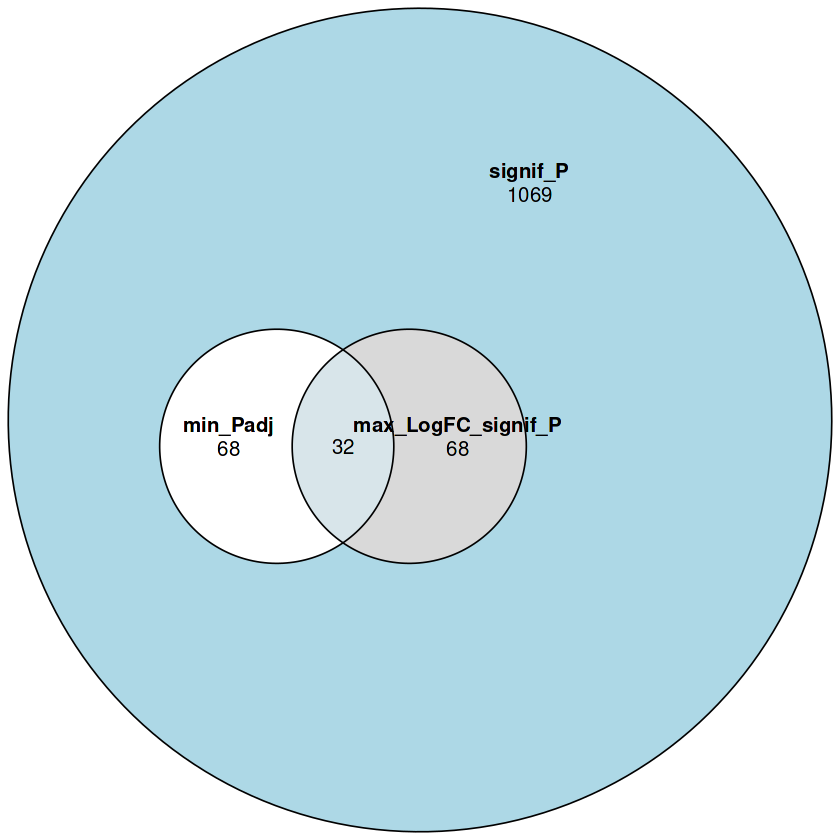

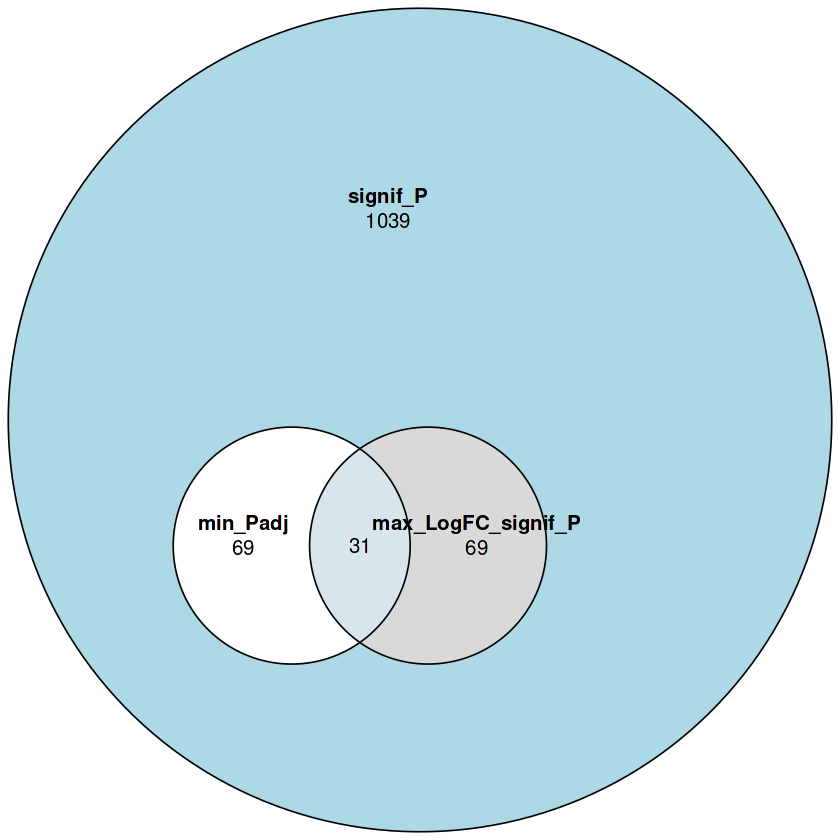

[1] "↑ CFS_3: Venn diagram for genes, selected by different approaches"


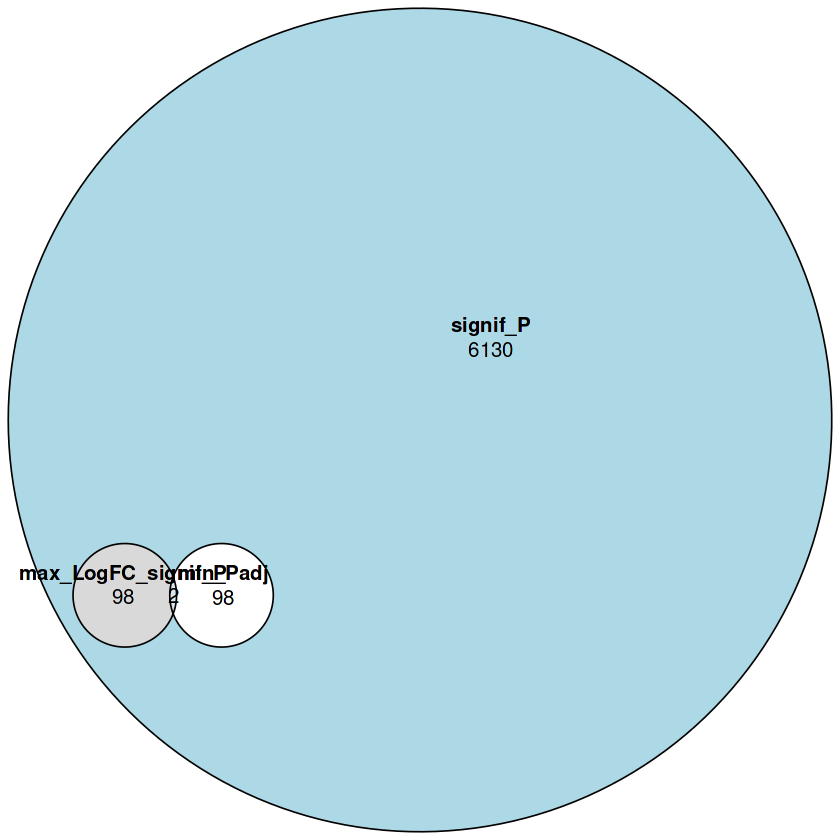

In [4]:
# Examine and compare DEGs for each CFS dataset

exp_code <- c("CFS_1", "CFS_2", "CFS_3")
for (code in exp_code) {
    res_df <- read_csv(paste0("/kaggle/input/project-cfs-three/", code, "/res_", code, ".csv"))
    res_df$gene_id <- res_df[['...1']]
    res_df <- left_join(res_df, ensembl_v113_annot_geneidunique, by = c("gene_id" ="Gene stable ID"))

    ### Volcano plot
    print(paste0("Volcano plot for ", code))
    output_filename <- paste0("volcano_plot_", code, ".png")
    png(filename = output_filename, width = 800, height = 600)
    volcano <- EnhancedVolcano(res_df,
                    lab = res_df[["Gene name"]], # Use gene names as labels
                    x = 'log2FoldChange',
                    y = 'pvalue')
    print(volcano)
    dev.off()

    # “Top-p” approach: 100 genes with the smallest adjusted p values
    top_min_p_adj <- res_df %>%
      arrange(padj) %>%
      slice_head(n = 100)
    
    # “Top-fold” approach:top-100 genes ranked by fold change and with p value less than 0.05
    top_max_logfc <- res_df %>%
      filter(pvalue < 0.05) %>%
      arrange(desc(abs(log2FoldChange))) %>%
      slice_head(n = 100)

    # All genes with p OR padj < 0.05
    p_all <- res_df %>% filter(pvalue < 0.05)
    padj_all <- res_df %>% filter(padj < 0.05)

    # Suboptimal stats
    subopt <- res_df %>%
      filter(pvalue < 0.05 & abs(log2FoldChange) > 1)

    
    # Saving the gene lists
    genelist_top_min_p_adj <- top_min_p_adj$gene_id
    genelist <- top_max_logfc$gene_id
    genelist_p_all <- p_all$gene_id
    genelist_padj_all <- padj_all$gene_id
    gene_list_subopt <- subopt$gene_id
    saveRDS(genelist_top_min_p_adj, file = paste0("genelist_p_", code, ".rds"))
    saveRDS(genelist, file = paste0("genelist_FC_", code, ".rds"))
    saveRDS(genelist_p_all, file = paste0("genelist_p_all_", code, ".rds"))
    saveRDS(genelist_padj_all, file = paste0("genelist_padj_all_", code, ".rds"))
    saveRDS(gene_list_subopt, file = paste0("gene_list_subopt_", code, ".rds"))
    
    
    # Create the Venn diagram
    venn_list <- list(
        min_Padj = genelist_top_min_p_adj,
        max_LogFC_signif_P = genelist,
        signif_P = genelist_p_all #,
        # signif_Padj = genelist_padj_all
      )

    fit1 <- euler(venn_list)
    venn <- plot(fit1, quantities = TRUE)
    print(venn)
    print(paste0("↑ ", code, ": Venn diagram for genes, selected by different approaches"))
}

[1] "Venn diagram for CFP genes, selected by criteria 'max |logFC| and p<0.05'"


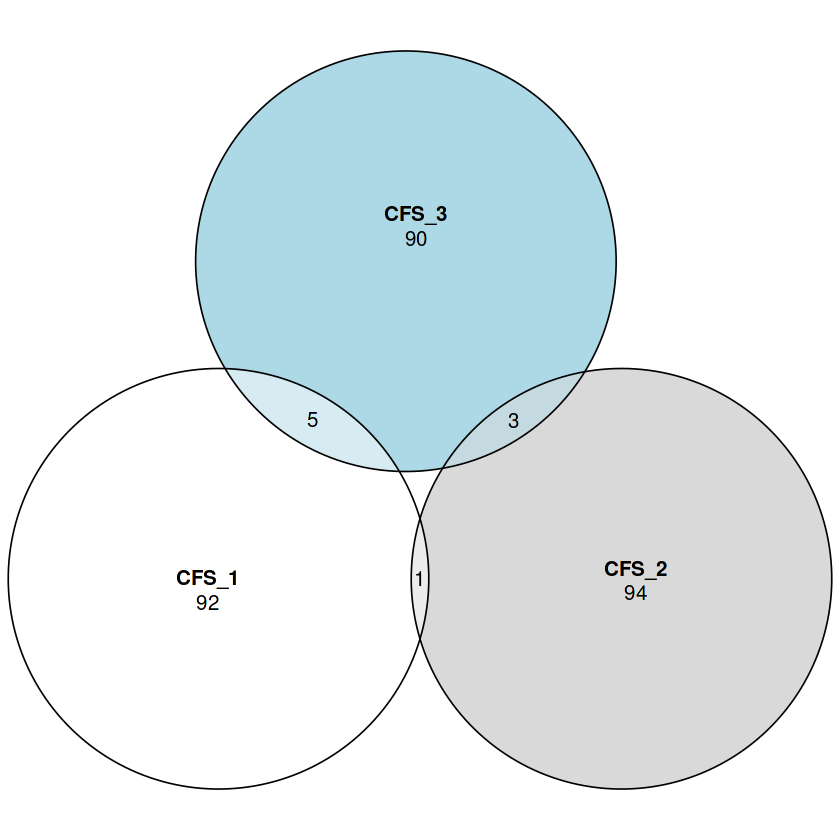

[1] "Venn diagram for CFP genes, selected by criteria 'min padj'"


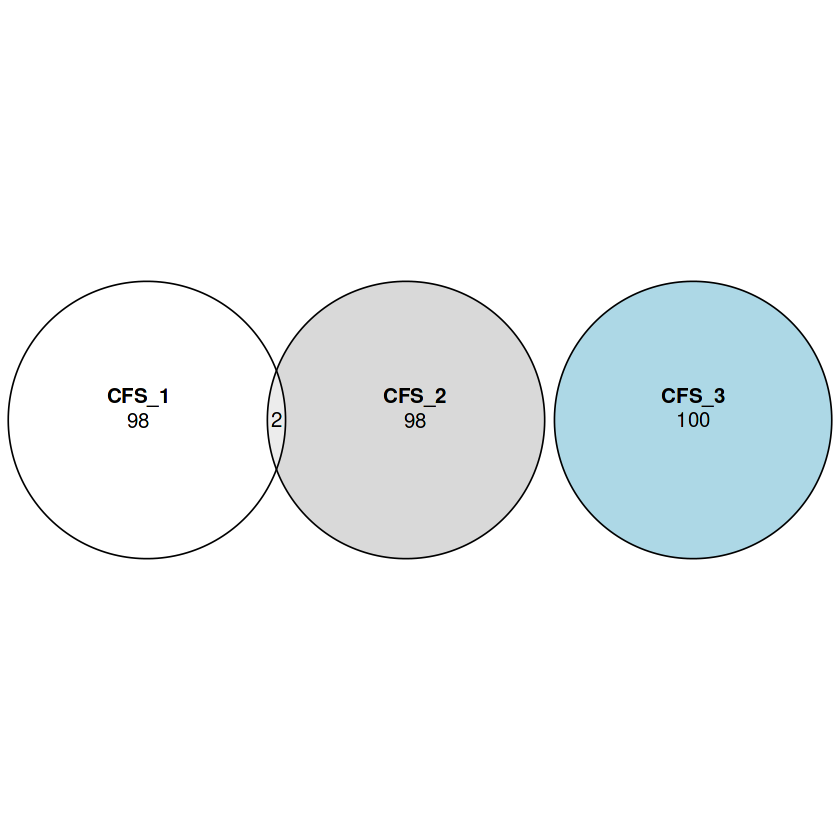

[1] "Venn diagram for CFP genes, selected by criteria 'p<0.05'"


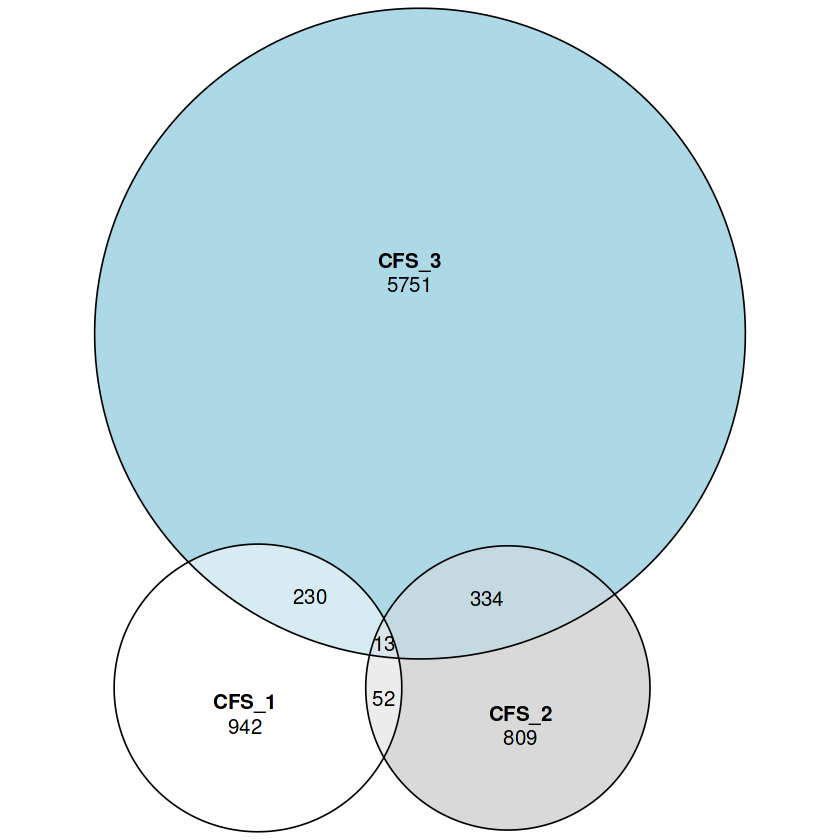

[1] "Venn diagram for CFP genes, selected by criteria 'padj<0.05'"


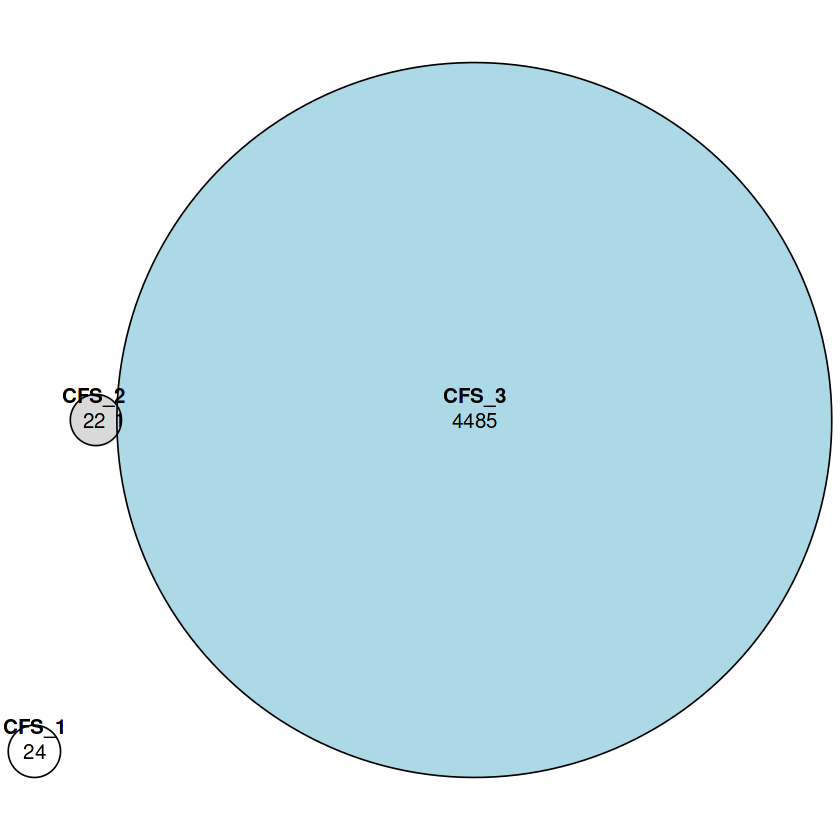

[1] "Venn diagram for CFP genes, selected by criteria 'p<0.05 and |logFC|>1'"


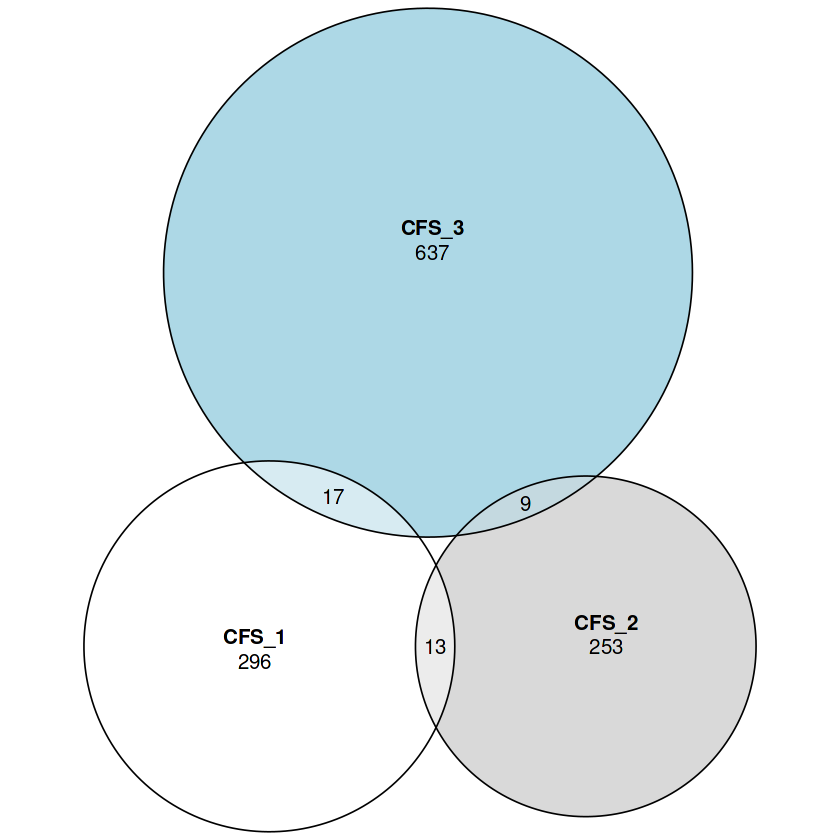

In [5]:
### Comparing DEGs selected by disserent criteria among three datasets

FC <- list(
    CFS_1 = readRDS("/kaggle/working/genelist_FC_CFS_1.rds"),
    CFS_2 = readRDS("/kaggle/working/genelist_FC_CFS_2.rds"),
    CFS_3 = readRDS("/kaggle/working/genelist_FC_CFS_3.rds")
  )

p <- list(
    CFS_1 = readRDS("/kaggle/working/genelist_p_CFS_1.rds"),
    CFS_2 = readRDS("/kaggle/working/genelist_p_CFS_2.rds"),
    CFS_3 = readRDS("/kaggle/working/genelist_p_CFS_3.rds")
  )

p_all <- list(
    CFS_1 = readRDS("/kaggle/working/genelist_p_all_CFS_1.rds"),
    CFS_2 = readRDS("/kaggle/working/genelist_p_all_CFS_2.rds"),
    CFS_3 = readRDS("/kaggle/working/genelist_p_all_CFS_3.rds")
  )

padj_all <- list(
    CFS_1 = readRDS("/kaggle/working/genelist_padj_all_CFS_1.rds"),
    CFS_2 = readRDS("/kaggle/working/genelist_padj_all_CFS_2.rds"),
    CFS_3 = readRDS("/kaggle/working/genelist_padj_all_CFS_3.rds")
  )

subopt <- list(
    CFS_1 = readRDS("/kaggle/working/gene_list_subopt_CFS_1.rds"),
    CFS_2 = readRDS("/kaggle/working/gene_list_subopt_CFS_2.rds"),
    CFS_3 = readRDS("/kaggle/working/gene_list_subopt_CFS_3.rds")
  )


plot(euler(FC), quantities = TRUE)
print(paste0("Venn diagram for CFP genes, selected by criteria 'max |logFC| and p<0.05'"))
plot(euler(p), quantities = TRUE)
print(paste0("Venn diagram for CFP genes, selected by criteria 'min padj'"))
plot(euler(p_all), quantities = TRUE)
print(paste0("Venn diagram for CFP genes, selected by criteria 'p<0.05'"))
plot(euler(padj_all), quantities = TRUE)
print(paste0("Venn diagram for CFP genes, selected by criteria 'padj<0.05'"))
plot(euler(subopt), quantities = TRUE)
print(paste0("Venn diagram for CFP genes, selected by criteria 'p<0.05 and |logFC|>1'"))

In [6]:
p_1 <- unlist(readRDS("/kaggle/working/genelist_p_all_CFS_1.rds"))
p_2 <- unlist(readRDS("/kaggle/working/genelist_p_all_CFS_2.rds"))
p_3 <- unlist(readRDS("/kaggle/working/genelist_p_all_CFS_3.rds"))

gene_counts <- table(c(p_1, p_2, p_3))
at_least_two <- names(gene_counts[gene_counts >= 2]) ### all genes that have p < 0.05 in at least two datasets
at_least_one <- unique(c(p_1, p_2, p_3)) ### all genes that have p < 0.05 in at least one dataset
length(at_least_two)
length(at_least_one)

[1] 629

[1] 8131

# Genes prioritisation with RFE, Boruta and RF
## Data preprocessing

In [ ]:
CFS_1_df_train <- read_csv("/kaggle/input/project-cfs-three/CFS_1/merged_df_CFS_1.csv", col_names=TRUE)
CFS_2_df_train <- read_csv("/kaggle/input/project-cfs-three/CFS_2/merged_df_CFS_2.csv", col_names=TRUE)
CFS_3_df_train <- read_csv("/kaggle/input/project-cfs-three/CFS_3/merged_df_CFS_3.csv", col_names=TRUE)

CFS_1_df_test <- read_csv("/kaggle/input/project-cfs-three/CFS_1/merged_df_test_CFS_1.csv", col_names=TRUE)
CFS_2_df_test <- read_csv("/kaggle/input/project-cfs-three/CFS_2/merged_df_test_CFS_2.csv", col_names=TRUE)
CFS_3_df_test <- read_csv("/kaggle/input/project-cfs-three/CFS_3/merged_df_test_CFS_3.csv", col_names=TRUE)

In [ ]:
### Merging CFS test and train datasets
colnames(CFS_3_df_train)[colnames(CFS_3_df_train) == "disease_status"] <- "disease_state"
remove_cols <- c('run_accession','sample_accession','experiment_accession','study_accession','submission_accession',
                 'tax_id','scientific_name','fastq_ftp','sra_ftp','sample_title')
CFS_3_df_train <- CFS_3_df_train %>% select(-remove_cols)

CFS_merged_df_train <- rbind(CFS_1_df_train[, names(CFS_3_df_train)], CFS_2_df_train[, names(CFS_3_df_train)], CFS_3_df_train)
CFS_merged_df_train <- CFS_merged_df_train %>%
  mutate(disease_state = case_when(
    disease_state == "healthy_control" ~ "healthy control",
    disease_state == "post-covid_ME-CFS" ~ "post-COVID ME/CFS",
    TRUE ~ disease_state
  ))
unique(CFS_merged_df_train$disease_state) ### checking the classes



colnames(CFS_3_df_test)[colnames(CFS_3_df_test) == "disease_status"] <- "disease_state"
remove_cols <- c('run_accession','sample_accession','experiment_accession','study_accession','submission_accession',
                 'tax_id','scientific_name','fastq_ftp','sra_ftp','sample_title')
CFS_3_df_test <- CFS_3_df_test %>% select(-remove_cols)

CFS_merged_df_test <- rbind(CFS_1_df_test[, names(CFS_3_df_test)], CFS_2_df_test[, names(CFS_3_df_test)], CFS_3_df_test)
CFS_merged_df_test <- CFS_merged_df_test %>%
  mutate(disease_state = case_when(
    disease_state == "healthy_control" ~ "healthy control",
    disease_state == "post-covid_ME-CFS" ~ "post-COVID ME/CFS",
    TRUE ~ disease_state
  ))
unique(CFS_merged_df_test$disease_state)

In [10]:
### Sample sizes between CFS datasets

dim(CFS_1_df_train) # has sex info
dim(CFS_2_df_train) # has sex (and run) info
dim(CFS_3_df_train) # has disease status only
dim(CFS_merged_df_train)  # has disease status only

dim(CFS_1_df_test) # has sex info
dim(CFS_2_df_test) # has sex (and run) info
dim(CFS_3_df_test) # has disease status only
dim(CFS_merged_df_test)  # has disease status only

[1]    49 38418

[1]    23 38419

[1]    30 38417

[1]   102 38417

[1]     8 38418

[1]     4 38419

[1]     6 38417

[1]    18 38417

In [13]:
### Getting feature matrix (X) and target variable (Y) for train and test datasets

CFS_merged_df_train <- as.data.frame(CFS_merged_df_train)
CFS_merged_df_test <- as.data.frame(CFS_merged_df_test)
rownames(CFS_merged_df_train) <- CFS_merged_df_train$Row.names
rownames(CFS_merged_df_test) <- CFS_merged_df_test$Row.names
CFS_merged_df_train$Row.names <- NULL
CFS_merged_df_test$Row.names <- NULL

X_train_CFS <- CFS_merged_df_train %>% dplyr::select(all_of(at_least_one))
Y_train_CFS <- CFS_merged_df_train$disease_state
X_test_CFS <- CFS_merged_df_test %>% dplyr::select(all_of(at_least_one))
Y_test_CFS <- CFS_merged_df_test$disease_state

Y_train_CFS <- as.factor(Y_train_CFS)
Y_test_CFS <- as.factor(Y_test_CFS)

In [15]:
### Calculate class weights

class_counts <- table(Y_train_CFS)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights <- total_samples / (num_classes * class_counts)

In [16]:
### Data standartisation

X_train_CFS_norm <- log(X_train_CFS + 1)
mean_values <- colMeans(X_train_CFS_norm)
std_values <- apply(X_train_CFS_norm, 2, sd)
X_train_CFS_norm <- scale(X_train_CFS_norm, center = mean_values, scale = std_values)
rownames(X_train_CFS_norm) <- rownames(X_train_CFS)

# Applying mean and SD calculated for train data on test data 

X_test_CFS_norm <- log(X_test_CFS + 1)
X_test_CFS_norm <- scale(X_test_CFS_norm, center = mean_values, scale = std_values)
rownames(X_test_CFS_norm) <- rownames(X_test_CFS)

## Recursive Feature Elimination

In [17]:
#RFE for Feature Selection

control <- rfeControl(functions = rfFuncs, 
                      method = "repeatedcv",
                      number = 10)

set.seed(123)
rfe_results <- rfe(
  x = X_train_CFS_norm,     
  y = Y_train_CFS,           
  sizes = seq(5, 100, by = 5),
  rfeControl = control
)

In [18]:
print(rfe_results)
saveRDS(rfe_results, "rfe_results.rds")

genelist_rfe_predict <- predictors(rfe_results)
saveRDS(genelist_rfe_predict, file = "genelist_rfe_predict.rds")


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 1 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.6427 0.4192     0.1658  0.2749         
        10   0.6891 0.5022     0.1382  0.2420         
        15   0.6709 0.4469     0.1651  0.3001         
        20   0.6780 0.4508     0.1624  0.2994         
        25   0.7104 0.5206     0.1319  0.2396         
        30   0.7022 0.5011     0.1531  0.2690         
        35   0.7175 0.5296     0.1297  0.2379        *
        40   0.6913 0.5067     0.1347  0.2233         
        45   0.7013 0.4920     0.1468  0.2918         
        50   0.6720 0.4410     0.1652  0.3169         
        55   0.6831 0.4648     0.1602  0.3023         
        60   0.6831 0.4648     0.1602  0.3023         
        65   0.6731 0.4485     0.1478  0.2827         
        70   0.6620 0.4350     0.1463  0.2619         
        75   0.6933 0.4962     0

## Boruta

In [ ]:
# Run the Boruta algorithm
set.seed(123)
boruta_results <- Boruta(
  Y_train_CFS ~ .,           
  data = data.frame(Y_train_CFS = Y_train_CFS, X_train_CFS_norm),
  doTrace = 2
)

In [21]:
boruta_final <- TentativeRoughFix(boruta_results)
saveRDS(boruta_final, "boruta_final.rds")
print(boruta_final)

selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)
saveRDS(selected_features, file = "genelist_boruta_predict.rds")

# attStats(boruta_final)

Boruta performed 99 iterations in 41.84743 secs.
Tentatives roughfixed over the last 99 iterations.
 82 attributes confirmed important: ENSG00000055044, ENSG00000058091,
ENSG00000062716, ENSG00000070831, ENSG00000077147 and 77 more;
 8049 attributes confirmed unimportant: ENSG00000000419,
ENSG00000000457, ENSG00000000971, ENSG00000001461, ENSG00000001561 and
8044 more;


## Random Forest

In [24]:
set.seed(123)
# Using all features
rf_model_all <- randomForest(
  x = X_train_CFS_norm,
  y = Y_train_CFS,
  ntree = 1501,
  importance = TRUE,
  classwt = class_weights,
  mtry = floor(sqrt(ncol(X_train_CFS_norm)))
)

pred_rf_all <- predict(rf_model_all, X_test_CFS_norm)

conf_matrix <- confusionMatrix(pred_rf_all, Y_test_CFS)
conf_matrix

Confusion Matrix and Statistics

                         Reference
Prediction                healthy control ME/CFS (non-PI)
  healthy control                       8               3
  ME/CFS (non-PI)                       0               1
  PI-ME/CFS (not specif.)               1               0
  post-COVID ME/CFS                     0               0
                         Reference
Prediction                PI-ME/CFS (not specif.) post-COVID ME/CFS
  healthy control                               2                 0
  ME/CFS (non-PI)                               0                 0
  PI-ME/CFS (not specif.)                       0                 0
  post-COVID ME/CFS                             0                 3

Overall Statistics
                                          
               Accuracy : 0.6667          
                 95% CI : (0.4099, 0.8666)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.1189          
                                

In [25]:
feature_importance_df <- as.data.frame(importance(rf_model_all))
feature_importance_df$Feature <- rownames(feature_importance_df)

# Sort by importance (e.g. MeanDecreaseAccuracy)
sorted_features <- feature_importance_df[order(-feature_importance_df$MeanDecreaseAccuracy), ]
top_features_RF <- head(sorted_features$Feature, 100) 
saveRDS(top_features_RF, file = "genelist_RF_predict.rds") ### Top-100 genes with highest MeanDecreaseAccuracy were selected

In [27]:
dim(sorted_features)
sum(sorted_features$MeanDecreaseAccuracy > 0)
sum(sorted_features$MeanDecreaseAccuracy > 2.35)

[1] 8131    7

[1] 2904

[1] 110

# Classsification of CFS subclasses with RF and SVM
## RandomForest

In [31]:
set.seed(123)

# Using RF-selected features
rf_model_rf <- randomForest(
  x = X_train_CFS_norm[, top_features_RF],
  y = Y_train_CFS,
  ntree = 1501,
  importance = TRUE,
  classwt = class_weights,
  mtry = floor(sqrt(length(top_features_RF)))
)

# Using Boruta-selected features
rf_model_boruta <- randomForest(
  x = X_train_CFS_norm[, selected_features],
  y = Y_train_CFS,
  ntree = 1501,
  importance = TRUE,
  classwt = class_weights,
  mtry = floor(sqrt(length(selected_features)))
)

# Using RFE-selected features
rf_model_rfe <- randomForest(
  x = X_train_CFS_norm[, genelist_rfe_predict],
  y = Y_train_CFS,
  ntree = 1501,
  importance = TRUE,
  classwt = class_weights,
  mtry = floor(sqrt(length(genelist_rfe_predict)))
)

# Evaluate performance on test data
pred_rf_rf <- predict(rf_model_rf, X_test_CFS_norm[, top_features_RF])
pred_rf_boruta <- predict(rf_model_boruta, X_test_CFS_norm[, selected_features])
pred_rf_rfe <- predict(rf_model_rfe, X_test_CFS_norm[, genelist_rfe_predict])

# Confusion matrices
confusion_rf_rf <- confusionMatrix(pred_rf_rf, Y_test_CFS)
confusion_rf_boruta <- confusionMatrix(pred_rf_boruta, Y_test_CFS)
confusion_rf_rfe <- confusionMatrix(pred_rf_rfe, Y_test_CFS)
print(confusion_rf_rf)
print(confusion_rf_boruta)
print(confusion_rf_rfe)

Confusion Matrix and Statistics

                         Reference
Prediction                healthy control ME/CFS (non-PI)
  healthy control                       8               2
  ME/CFS (non-PI)                       1               2
  PI-ME/CFS (not specif.)               0               0
  post-COVID ME/CFS                     0               0
                         Reference
Prediction                PI-ME/CFS (not specif.) post-COVID ME/CFS
  healthy control                               2                 0
  ME/CFS (non-PI)                               0                 0
  PI-ME/CFS (not specif.)                       0                 0
  post-COVID ME/CFS                             0                 3

Overall Statistics
                                          
               Accuracy : 0.7222          
                 95% CI : (0.4652, 0.9031)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.04813         
                                

## Support Vector Machine


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
  100 0.001

- best performance: 0.14 

- Detailed performance results:
    cost gamma     error dispersion
1  1e-02 0.010 0.9145455 0.10927594
2  1e-01 0.010 0.5427273 0.18709759
3  1e+00 0.010 0.2972727 0.15902885
4  1e+01 0.010 0.1590909 0.10809733
5  5e+01 0.010 0.1590909 0.12700188
6  1e+02 0.010 0.1590909 0.12700188
7  1e-02 0.001 0.9145455 0.10927594
8  1e-01 0.001 0.8654545 0.12660721
9  1e+00 0.001 0.5109091 0.17621675
10 1e+01 0.001 0.2572727 0.14507843
11 5e+01 0.001 0.1781818 0.09163348
12 1e+02 0.001 0.1400000 0.11737878
13 1e-02 0.010 0.9145455 0.10927594
14 1e-01 0.010 0.5427273 0.18709759
15 1e+00 0.010 0.2972727 0.15902885
16 1e+01 0.010 0.1590909 0.10809733
17 5e+01 0.010 0.1590909 0.12700188
18 1e+02 0.010 0.1590909 0.12700188
19 1e-02 0.100 0.9145455 0.10927594
20 1e-01 0.100 0.9145455 0.10927594
21 1e+00 0.100 0.4318182 0.15782323
22 1e+01 0.100 0.4218182 0.176

Confusion Matrix and Statistics

                         Reference
Prediction                healthy control ME/CFS (non-PI)
  healthy control                       5               2
  ME/CFS (non-PI)                       3               2
  PI-ME/CFS (not specif.)               1               0
  post-COVID ME/CFS                     0               0
                         Reference
Prediction                PI-ME/CFS (not specif.) post-COVID ME/CFS
  healthy control                               0                 1
  ME/CFS (non-PI)                               0                 0
  PI-ME/CFS (not specif.)                       2                 0
  post-COVID ME/CFS                             0                 2

Overall Statistics
                                         
               Accuracy : 0.6111         
                 95% CI : (0.3575, 0.827)
    No Information Rate : 0.5            
    P-Value [Acc > NIR] : 0.2403         
                                     

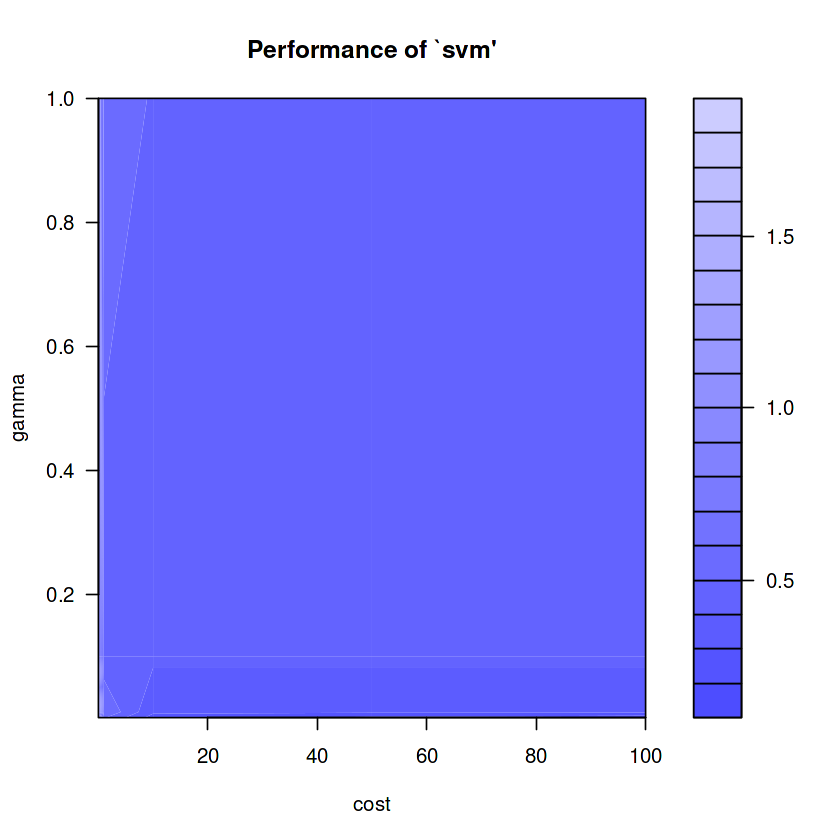


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
  100 0.001

- best performance: 0.1181818 

- Detailed performance results:
    cost      gamma     error dispersion
1  1e-02 0.01219512 0.9054545 0.11348070
2  1e-01 0.01219512 0.5827273 0.18716629
3  1e+00 0.01219512 0.2890909 0.20345049
4  1e+01 0.01219512 0.1472727 0.08461005
5  5e+01 0.01219512 0.1272727 0.08119855
6  1e+02 0.01219512 0.1272727 0.08119855
7  1e-02 0.00100000 0.9054545 0.11348070
8  1e-01 0.00100000 0.9054545 0.11348070
9  1e+00 0.00100000 0.4927273 0.15390837
10 1e+01 0.00100000 0.2672727 0.15164843
11 5e+01 0.00100000 0.1572727 0.06990089
12 1e+02 0.00100000 0.1181818 0.04328138
13 1e-02 0.01000000 0.9054545 0.11348070
14 1e-01 0.01000000 0.5627273 0.18389970
15 1e+00 0.01000000 0.3181818 0.18382728
16 1e+01 0.01000000 0.1572727 0.10748396
17 5e+01 0.01000000 0.1272727 0.08119855
18 1e+02 0.01000000 0.1272727 0.08119855
19 1e-02 0.10000000 0.9054545 0.113480

Confusion Matrix and Statistics

                         Reference
Prediction                healthy control ME/CFS (non-PI)
  healthy control                       7               2
  ME/CFS (non-PI)                       2               2
  PI-ME/CFS (not specif.)               0               0
  post-COVID ME/CFS                     0               0
                         Reference
Prediction                PI-ME/CFS (not specif.) post-COVID ME/CFS
  healthy control                               0                 0
  ME/CFS (non-PI)                               0                 0
  PI-ME/CFS (not specif.)                       2                 0
  post-COVID ME/CFS                             0                 3

Overall Statistics
                                          
               Accuracy : 0.7778          
                 95% CI : (0.5236, 0.9359)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.01544         
                                

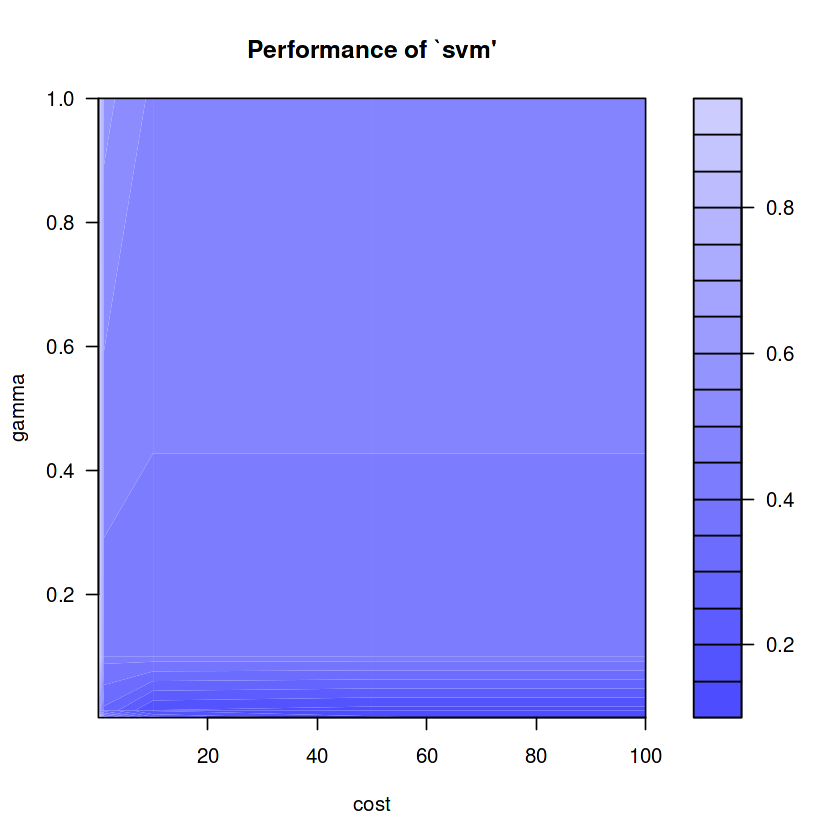


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
  100  0.01

- best performance: 0.2718182 

- Detailed performance results:
    cost      gamma     error dispersion
1  1e-02 0.02857143 0.8627273  0.1135009
2  1e-01 0.02857143 0.5472727  0.1026553
3  1e+00 0.02857143 0.4518182  0.1364007
4  1e+01 0.02857143 0.2918182  0.1992387
5  5e+01 0.02857143 0.3018182  0.1966104
6  1e+02 0.02857143 0.3018182  0.2002661
7  1e-02 0.00100000 0.8627273  0.1135009
8  1e-01 0.00100000 0.8627273  0.1135009
9  1e+00 0.00100000 0.5663636  0.1136303
10 1e+01 0.00100000 0.4227273  0.1190142
11 5e+01 0.00100000 0.3427273  0.1332679
12 1e+02 0.00100000 0.2827273  0.1225270
13 1e-02 0.01000000 0.8627273  0.1135009
14 1e-01 0.01000000 0.6154545  0.1490743
15 1e+00 0.01000000 0.4127273  0.1159621
16 1e+01 0.01000000 0.3127273  0.1185464
17 5e+01 0.01000000 0.2809091  0.2038856
18 1e+02 0.01000000 0.2718182  0.1855897
19 1e-02 0.10000000 0.8627273  0.11350

Confusion Matrix and Statistics

                         Reference
Prediction                healthy control ME/CFS (non-PI)
  healthy control                       4               1
  ME/CFS (non-PI)                       4               3
  PI-ME/CFS (not specif.)               1               0
  post-COVID ME/CFS                     0               0
                         Reference
Prediction                PI-ME/CFS (not specif.) post-COVID ME/CFS
  healthy control                               1                 1
  ME/CFS (non-PI)                               0                 0
  PI-ME/CFS (not specif.)                       1                 0
  post-COVID ME/CFS                             0                 2

Overall Statistics
                                          
               Accuracy : 0.5556          
                 95% CI : (0.3076, 0.7847)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.4073          
                                

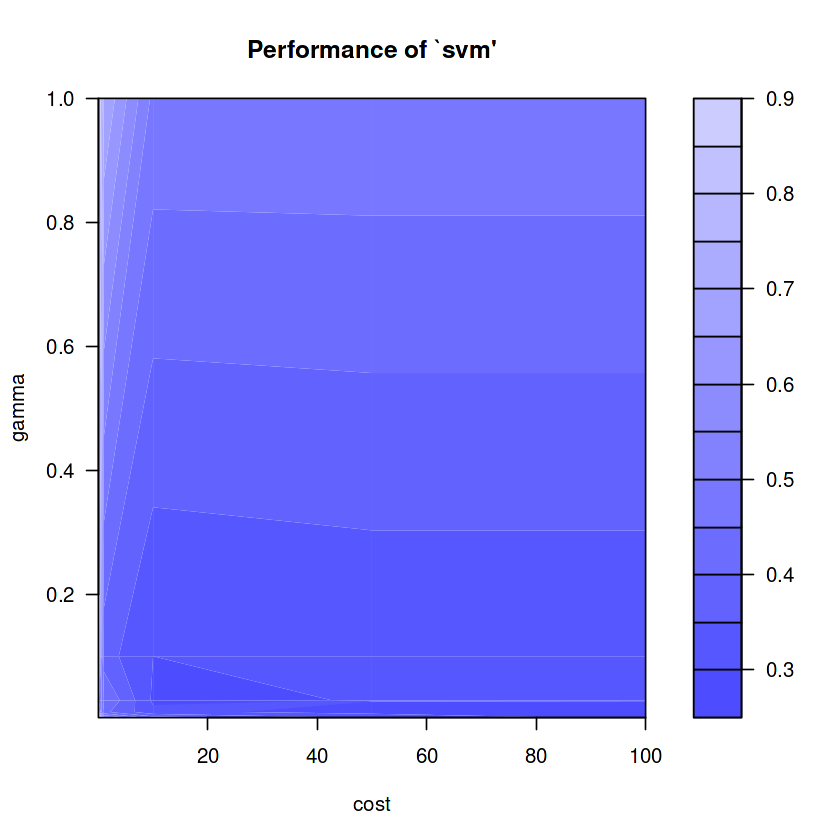

In [32]:
set.seed(123)

# Using RF-selected features
svm_tuned <- tune(svm,
  Y_train_CFS ~ ., 
  data = data.frame(Y_train_CFS = Y_train_CFS, X_train_CFS_norm[, top_features_RF]),
  kernel = "radial", 
  type = "C-classification",
  ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100), 
                gamma = c(1 / length(top_features_RF), 0.001, 0.01, 0.1, 1)),
  class.weights = class_weights,
  tunecontrol = tune.control(cross = 10)
)
# plot(svm_tuned)
summary(svm_tuned)
best_model_rf <- svm_tuned$best.model

# Evaluate the best model on the test set
pred_svm_rf <- predict(best_model_rf, X_test_CFS_norm[, top_features_RF])
confusion_svm_rf <- confusionMatrix(pred_svm_rf, Y_test_CFS)
print(confusion_svm_rf)


# Using Boruta-selected features
svm_tuned <- tune(svm,
  Y_train_CFS ~ ., 
  data = data.frame(Y_train_CFS = Y_train_CFS, X_train_CFS_norm[, selected_features]),
  kernel = "radial", 
  type = "C-classification",
  ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100), 
                gamma = c(1 / length(selected_features), 0.001, 0.01, 0.1, 1)),
  class.weights = class_weights,
  tunecontrol = tune.control(cross = 10)
)
# plot(svm_tuned)
summary(svm_tuned)
best_model_boruta <- svm_tuned$best.model

pred_svm_boruta <- predict(best_model_boruta, X_test_CFS_norm[, selected_features])
confusion_svm_boruta <- confusionMatrix(pred_svm_boruta, Y_test_CFS)
print(confusion_svm_boruta)



# Using RFE-selected features
svm_tuned <- tune(svm,
  Y_train_CFS ~ ., 
  data = data.frame(Y_train_CFS = Y_train_CFS, X_train_CFS_norm[, genelist_rfe_predict]),
  kernel = "radial", 
  type = "C-classification",
  ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100), 
                gamma = c(1 / length(genelist_rfe_predict), 0.001, 0.01, 0.1, 1)),
  class.weights = class_weights,
  tunecontrol = tune.control(cross = 10)
)
# plot(svm_tuned)
summary(svm_tuned)
best_model_rfe <- svm_tuned$best.model

pred_svm_rfe <- predict(best_model_rfe, X_test_CFS_norm[, genelist_rfe_predict])
confusion_svm_rfe <- confusionMatrix(pred_svm_rfe, Y_test_CFS)
print(confusion_svm_rfe)

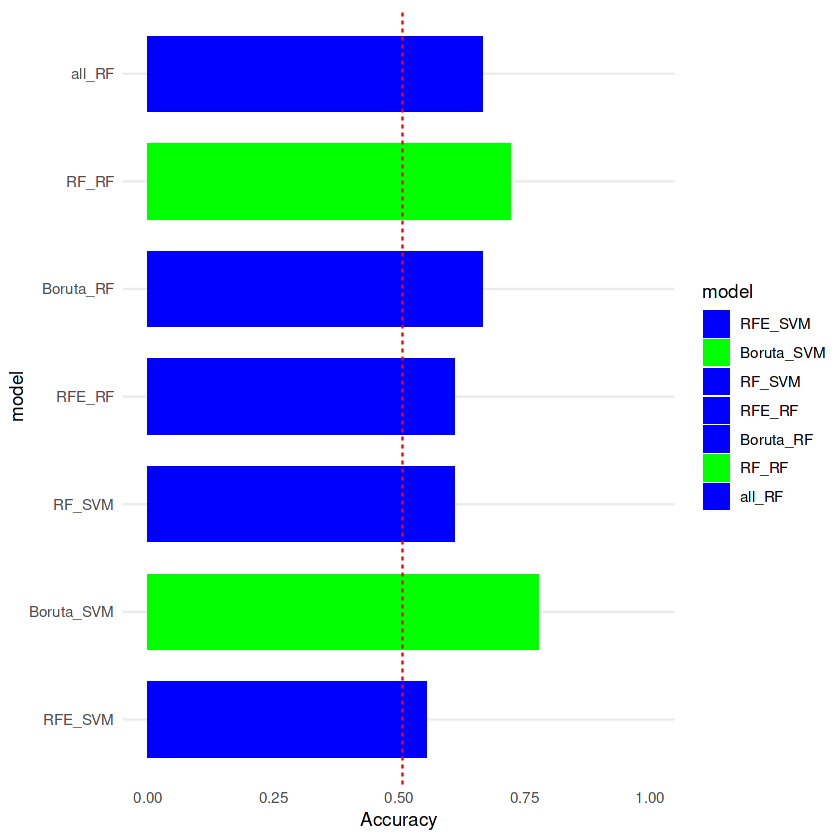

In [51]:
# Barplot for visualising models accuracy

df <- data.frame(
  model = c("all_RF", "RF_RF", "Boruta_RF", "RFE_RF", "RF_SVM", "Boruta_SVM", "RFE_SVM"),
  Accuracy = c(0.6667, 0.7222, 0.6667, 0.6111, 0.6111, 0.7778, 0.5556),
  Acc_CI_min = c(0.4099, 0.4652, 0.4099, 0.3575, 0.3575, 0.5236, 0.3076),
  Acc_CI_max = c(0.8666, 0.9031, 0.8666, 0.827, 0.827, 0.9359, 0.7847),
  p_value = c(0.1189, 0.04813, 0.1189, 0.2403, 0.240, 0.01544, 0.4073)
)

df$model <- factor(df$model, levels = rev(df$model))

ggplot(df, aes(x = model, y = Accuracy)) +
  geom_bar(stat = "identity", aes(fill = model), , width = 0.7) +
  geom_hline(yintercept = 0.508333333333333, linetype = "dashed", color = "red") +
  coord_flip() +                                     
  # geom_errorbar(aes(ymin = Acc_CI_min, ymax = Acc_CI_max), width = 0.1) +
  scale_y_continuous(limits = c(0, 1)) +
  scale_fill_manual(values = c("blue", "green", "blue", "blue", "blue", "green", "blue")) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank())

# Enrichment analysis

In [38]:
### Selection of genes specific to each CFS subtype based on RF-based prioritisation
### From first RF run (all_RF)

# Function that checks that the value in the selected column is maximal and greater than others by threshold
select_rows_by_column <- function(df, col_index, threshold = 1.5) {
  selected_rows <- which(apply(df, 1, function(x) {
    x_col <- x[col_index]
    x_others <- x[-col_index]
    return(x_col == max(x) & all(x_col >= x_others * threshold))
  }))
  return(selected_rows)}

feature_importance_df <- as.data.frame(importance(rf_model_all))
feature_importance_df[, c('MeanDecreaseAccuracy', 'MeanDecreaseGini')] <- list(NULL)
feature_importance_df <- feature_importance_df[rowSums(feature_importance_df) != 0, ]


selected_rows <- select_rows_by_column(feature_importance_df, 2)                 
rownames_selected <- rownames(feature_importance_df)[selected_rows]
length(rownames_selected)
saveRDS(rownames_selected, file = "ALL_ME-CFS (non-PI)_RF.rds")

selected_rows <- select_rows_by_column(feature_importance_df, 3)                 
rownames_selected <- rownames(feature_importance_df)[selected_rows]
length(rownames_selected)
saveRDS(rownames_selected, file = "ALL_PI-ME-CFS (not specif.)_RF.rds")

selected_rows <- select_rows_by_column(feature_importance_df, 4)                 
rownames_selected <- rownames(feature_importance_df)[selected_rows]
length(rownames_selected)
saveRDS(rownames_selected, file = "ALL_post-COVID ME-CFS_RF.rds")

[1] 8131    6

[1] 4269    4

[1] 1368

[1] 1112

[1] 1120

In [40]:
### From seconf RF run (RF_RF)

feature_importance_rf_fin <- as.data.frame(importance(rf_model_rf))
feature_importance_rf_fin[, c('MeanDecreaseAccuracy', 'MeanDecreaseGini')] <- list(NULL)

selected_rows <- which(apply(feature_importance_rf_fin, 1, function(x) x[2] == max(x)))                 
rownames_selected <- rownames(feature_importance_rf_fin)[selected_rows]
length(rownames_selected)
saveRDS(rownames_selected, file = "ME-CFS (non-PI)_RF.rds")

selected_rows <- which(apply(feature_importance_rf_fin, 1, function(x) x[3] == max(x)))                 
rownames_selected <- rownames(feature_importance_rf_fin)[selected_rows]
length(rownames_selected)
saveRDS(rownames_selected, file = "PI-ME-CFS (not specif.)_RF.rds")

selected_rows <- which(apply(feature_importance_rf_fin, 1, function(x) x[4] == max(x)))                 
rownames_selected <- rownames(feature_importance_rf_fin)[selected_rows]
length(rownames_selected)
saveRDS(rownames_selected, file = "post-COVID ME-CFS_RF.rds")

[1] 41

[1] 15

[1] 38

In [42]:
genelist_FC_CFS_1 <- readRDS("/kaggle/working/genelist_FC_CFS_1.rds")
genelist_FC_CFS_2 <- readRDS("/kaggle/working/genelist_FC_CFS_2.rds")
genelist_FC_CFS_3 <- readRDS("/kaggle/working/genelist_FC_CFS_3.rds")
genelist_p_all_CFS_1 <- readRDS("/kaggle/working/genelist_p_all_CFS_1.rds")
genelist_p_all_CFS_2 <- readRDS("/kaggle/working/genelist_p_all_CFS_2.rds")
genelist_p_all_CFS_3 <- readRDS("/kaggle/working/genelist_p_all_CFS_3.rds")

# Unique genes for each CFS subtype based on top-fold" approach
unique_to_CFS_1_FC <- setdiff(genelist_FC_CFS_1, union(genelist_FC_CFS_2, genelist_FC_CFS_3))
unique_to_CFS_2_FC <- setdiff(genelist_FC_CFS_2, union(genelist_FC_CFS_1, genelist_FC_CFS_3))
unique_to_CFS_3_FC <- setdiff(genelist_FC_CFS_3, union(genelist_FC_CFS_1, genelist_FC_CFS_2))

# Genes that have p < 0.05 in all three datasets
common_CFS <- intersect(intersect(genelist_p_all_CFS_1, genelist_p_all_CFS_2), genelist_p_all_CFS_3)

CFS_1_RF_1 <- readRDS("/kaggle/working/ALL_ME-CFS (non-PI)_RF.rds")
CFS_2_RF_1 <- readRDS("/kaggle/working/ALL_PI-ME-CFS (not specif.)_RF.rds")
CFS_3_RF_1 <- readRDS("/kaggle/working/ALL_post-COVID ME-CFS_RF.rds")
CFS_1_RF_2 <- readRDS("/kaggle/working/ME-CFS (non-PI)_RF.rds")
CFS_2_RF_2 <- readRDS("/kaggle/working/PI-ME-CFS (not specif.)_RF.rds")
CFS_3_RF_2 <- readRDS("/kaggle/working/post-COVID ME-CFS_RF.rds")

In [67]:
# ### GO enrichment analysis
gene_lists <- list(common_CFS, unique_to_CFS_1_FC, unique_to_CFS_2_FC, unique_to_CFS_3_FC,
                   CFS_1_RF_1, CFS_2_RF_1, CFS_3_RF_1,
                   CFS_1_RF_2, CFS_2_RF_2, CFS_3_RF_2)

gene_lists_index <- c("common_CFS", "unique_to_CFS_1_FC", "unique_to_CFS_2_FC", "unique_to_CFS_3_FC",
                      "CFS_1_RF_1", "CFS_2_RF_1", "CFS_3_RF_1",
                      "CFS_1_RF_2", "CFS_2_RF_2", "CFS_3_RF_2")


for (i in seq_along(gene_lists)) {
  print(paste0("List ", gene_lists_index[i], " in progress"))
  
  if (!is.null(gene_lists[[i]]) && length(gene_lists[[i]]) > 0) {
    go_results <- enrichGO(
      gene = gene_lists[[i]],
      OrgDb = org.Hs.eg.db,
      keyType = "ENSEMBL",
      ont = "ALL",
      # ont = "BP",
      pAdjustMethod = "BH",
      # pvalueCutoff = 1,
      # qvalueCutoff = 1,
      pvalueCutoff = 0.05,
      qvalueCutoff = 0.2,
      readable = TRUE)

    write.csv(go_results, file = paste0(gene_lists_index[i], "_go_results_ALL.csv"), row.names = FALSE)
  } else {
    print(paste0("List ", gene_lists_index[i], " is empty or null. Skipping..."))
  }
}

csv_files <- paste0(gene_lists_index, "_go_results_ALL.csv")
sheet_list <- setNames(
  lapply(csv_files, read.csv),
  tools::file_path_sans_ext(basename(csv_files)))
write_xlsx(sheet_list, "go_results_ALL_merged.xlsx")

[1] "List common_CFS in progress"
[1] "List unique_to_CFS_1_FC in progress"
[1] "List unique_to_CFS_2_FC in progress"
[1] "List unique_to_CFS_3_FC in progress"
[1] "List CFS_1_RF_1 in progress"
[1] "List CFS_2_RF_1 in progress"
[1] "List CFS_3_RF_1 in progress"
[1] "List CFS_1_RF_2 in progress"
[1] "List CFS_2_RF_2 in progress"
[1] "List CFS_3_RF_2 in progress"
